In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from solardatatools import signal_decompositions as sd

np.random.seed(12) # reload each time to get first instance of seed

# Set up simple numerical examples for tests

#  l2_l1d1_l2d2p365

In [2]:
    """
    This performs total variation filtering with the addition of a seasonal baseline fit. This introduces a new
    signal to the model that is smooth and periodic on a yearly time frame. This does a better job of describing real,
    multi-year solar PV power data sets, and therefore does an improved job of estimating the discretely changing
    signal.

    :param signal: A 1d numpy array (must support boolean indexing) containing the signal of interest
    :param c1: The regularization parameter to control the total variation in the final output signal
    :param c2: The regularization parameter to control the smoothness of the seasonal signal
    :return: A 1d numpy array containing the filtered signal
    """;

## signal 

In [3]:
# smooth + yearly periodic + gaussian noise signals
t = np.linspace(0, 1000, 365*2)
signal1 = np.sin(2 * np.pi * t * 1 / (500)) # sine wave, smooth periodic

X_real = np.zeros((2, len(t)), dtype=float)
X_real[0] = 0.3 * np.random.randn(len(signal1)) # noise in form of sigma * np.random.randn(...) + mu
X_real[1] = signal1 


y = np.sum(X_real, axis=0)

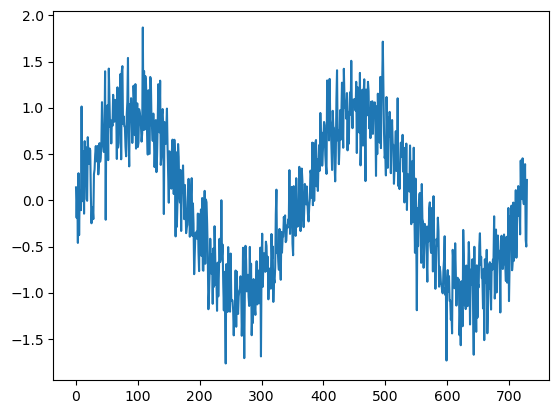

In [4]:
plt.plot(y)

## sav/load as df

In [5]:
fname = "test_l2_l1d1_l2d2p365_data_input.csv"
# try:
#     signal = pd.read_csv(fname)["test_signal"].array
#     test_df = pd.DataFrame(signal, columns=["test_signal"])
#     #df_full = pd.read_csv(fname)
# except FileNotFoundError:
test_df = pd.DataFrame(y, columns=["test_signal"])

### CVXPY exepcted output
Try OSQP, SCS, ECOS, and MOSEK and confirm that all that run give the same objective value

## start w/ signal <= 365

In [6]:
signal_365 = y[:365]

In [7]:
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK")

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_365"]

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_seas_mosek_365"]

In [8]:
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "SCS")

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_scs_365"]

cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_seas_scs_365"]

In [9]:
# random weights 
rand_residual_weights = np.random.uniform(10, 200, len(signal_365))
rand_tv_weights = np.random.uniform(10, 200, len(signal_365)-1)

In [10]:
cols = test_df.columns

test_df = pd.concat([test_df, pd.Series(rand_residual_weights)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(rand_tv_weights)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["rand_residual_weights_365", "rand_tv_weights_365"]

### add resuts w/ weights

In [11]:
# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", residual_weights=test_df["rand_residual_weights_365"].dropna())
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_rw_365", "expected_s_seas_mosek_rw_365"]

s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", tv_weights=test_df["rand_tv_weights_365"].dropna())
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_mosek_tvw_365", "expected_s_seas_mosek_tvw_365"]

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "SCS", residual_weights=test_df["rand_residual_weights_365"].dropna())
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_scs_rw_365", "expected_s_seas_scs_rw_365"]

s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "SCS", tv_weights=test_df["rand_tv_weights_365"].dropna())
cols = test_df.columns
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)
test_df.columns = list(cols) + ["expected_s_hat_scs_tvw_365", "expected_s_seas_scs_tvw_365"]

### add transition pnt

In [12]:
idx = 100
cols = test_df.columns

s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", transition_locs=idx)
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)

s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "SCS", transition_locs=idx)
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)

test_df.columns = list(cols) + ["expected_s_hat_mosek_transition_100_365", 
                                "expected_s_seas_mosek_transition_100_365",
                                "expected_s_hat_scs_transition_100_365",
                                "expected_s_seas_scs_transition_100_365"]

### max seas constraint  

In [13]:
cols = test_df.columns

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "MOSEK", seas_max=0.5) # is this reasonable?
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_365, solver = "SCS", seas_max=0.5) # is this reasonable?
test_df = pd.concat([test_df, pd.Series(s_hat)], ignore_index=True, axis=1)
test_df = pd.concat([test_df, pd.Series(s_seas)], ignore_index=True, axis=1)

test_df.columns = list(cols) + ["expected_s_hat_mosek_seas_max_365", 
                                "expected_s_seas_mosek_seas_max_365",
                                "expected_s_hat_mosek_scs_max_365",
                                "expected_s_seas_mosek_scs_max_365"]

In [14]:
test_df

,test_signal,expected_s_hat_mosek_365,expected_s_seas_mosek_365,expected_s_hat_scs_365,expected_s_seas_scs_365,rand_residual_weights_365,rand_tv_weights_365,expected_s_hat_mosek_rw_365,expected_s_seas_mosek_rw_365,expected_s_hat_mosek_tvw_365,...,expected_s_hat_scs_tvw_365,expected_s_seas_scs_tvw_365,expected_s_hat_mosek_transition_100_365,expected_s_seas_mosek_transition_100_365,expected_s_hat_scs_transition_100_365,expected_s_seas_scs_transition_100_365,expected_s_hat_mosek_seas_max_365,expected_s_seas_mosek_seas_max_365,expected_s_hat_mosek_scs_max_365,expected_s_seas_mosek_scs_max_365
0,0.141896,-0.025519,0.022781,-0.025519,0.022809,181.195692,18.168382,-4.137423,4.279318,-0.025519,...,-0.025519,0.022789,-0.110152,0.106502,-0.110018,0.106356,0.316662,-0.280359,0.316665,-0.280455
1,-0.187191,-0.025519,0.037688,-0.025519,0.037716,49.264197,121.426040,-4.447952,4.260761,-0.025519,...,-0.025519,0.037698,-0.110152,0.121525,-0.110018,0.121380,0.316662,-0.265661,0.316665,-0.265755
2,0.107201,-0.025519,0.052598,-0.025519,0.052625,103.522174,63.685220,-4.135028,4.242229,-0.025519,...,-0.025519,0.052608,-0.110152,0.136550,-0.110018,0.136406,0.316662,-0.250961,0.316665,-0.251053
3,-0.458530,-0.025519,0.067509,-0.025519,0.067536,135.381248,43.284007,-4.682227,4.223696,-0.025519,...,-0.025519,0.067520,-0.110152,0.151576,-0.110018,0.151433,0.316662,-0.236261,0.316665,-0.236351
4,0.294840,-0.025519,0.082421,-0.025518,0.082448,165.802224,116.224699,-3.910349,4.205188,-0.025519,...,-0.025519,0.082434,-0.110152,0.166604,-0.110018,0.166462,0.316662,-0.221561,0.316665,-0.221648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0.190580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
726,0.392721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
727,-0.423948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
728,-0.497811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## signal w/ len > 365

In [15]:
signal_730 = y
# cvxpy output w/ default args

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "MOSEK")
test_df["expected_s_hat_mosek"] = s_hat
test_df["expected_s_seas_mosek"] = s_seas

# SCS 
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "SCS")
test_df["expected_s_hat_scs"] = s_hat
test_df["expected_s_seas_scs"] = s_seas

#############################################################
# w/ random weights 
rand_residual_weights = np.random.uniform(1, 100, len(signal_730))
rand_tv_weights = np.random.uniform(10, 200, len(signal_730)-1)
test_df["rand_residual_weights"] = rand_residual_weights

In [16]:
test_df

,test_signal,expected_s_hat_mosek_365,expected_s_seas_mosek_365,expected_s_hat_scs_365,expected_s_seas_scs_365,rand_residual_weights_365,rand_tv_weights_365,expected_s_hat_mosek_rw_365,expected_s_seas_mosek_rw_365,expected_s_hat_mosek_tvw_365,...,expected_s_seas_scs_transition_100_365,expected_s_hat_mosek_seas_max_365,expected_s_seas_mosek_seas_max_365,expected_s_hat_mosek_scs_max_365,expected_s_seas_mosek_scs_max_365,expected_s_hat_mosek,expected_s_seas_mosek,expected_s_hat_scs,expected_s_seas_scs,rand_residual_weights
0,0.141896,-0.025519,0.022781,-0.025519,0.022809,181.195692,18.168382,-4.137423,4.279318,-0.025519,...,0.106356,0.316662,-0.280359,0.316665,-0.280455,-0.01003,0.025538,-0.010126,0.025614,93.070369
1,-0.187191,-0.025519,0.037688,-0.025519,0.037716,49.264197,121.426040,-4.447952,4.260761,-0.025519,...,0.121380,0.316662,-0.265661,0.316665,-0.265755,-0.01003,0.040113,-0.010126,0.040190,46.890610
2,0.107201,-0.025519,0.052598,-0.025519,0.052625,103.522174,63.685220,-4.135028,4.242229,-0.025519,...,0.136406,0.316662,-0.250961,0.316665,-0.251053,-0.01003,0.054723,-0.010126,0.054799,16.627400
3,-0.458530,-0.025519,0.067509,-0.025519,0.067536,135.381248,43.284007,-4.682227,4.223696,-0.025519,...,0.151433,0.316662,-0.236261,0.316665,-0.236351,-0.01003,0.069377,-0.010125,0.069451,79.232036
4,0.294840,-0.025519,0.082421,-0.025518,0.082448,165.802224,116.224699,-3.910349,4.205188,-0.025519,...,0.166462,0.316662,-0.221561,0.316665,-0.221648,-0.01003,0.084083,-0.010125,0.084152,24.665182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0.190580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.01003,-0.046894,-0.009937,-0.046864,60.192550
726,0.392721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.01003,-0.032412,-0.009936,-0.032372,95.510809
727,-0.423948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.01003,-0.017943,-0.009935,-0.017892,5.471046
728,-0.497811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.01003,-0.003471,-0.009935,-0.003410,71.096733


In [17]:



cols = test_df.columns 
test_df = pd.concat([test_df, pd.Series(rand_tv_weights)], ignore_index=True, axis=1)

test_df.columns = list(cols) + ["rand_tv_weights"]

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "MOSEK", residual_weights=test_df["rand_residual_weights"])
test_df["expected_s_hat_mosek_rw"] = s_hat
test_df["expected_s_seas_mosek_rw"] = s_seas

s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "MOSEK", tv_weights=test_df["rand_tv_weights"].dropna())
test_df["expected_s_hat_mosek_tvw"] = s_hat
test_df["expected_s_seas_mosek_tvw"] = s_seas

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "SCS", residual_weights=test_df["rand_residual_weights"])
test_df["expected_s_hat_scs_rw"] = s_hat
test_df["expected_s_seas_scs_rw"] = s_seas

s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "SCS", tv_weights=test_df["rand_tv_weights"].dropna())
test_df["expected_s_hat_scs_tvw"] = s_hat
test_df["expected_s_seas_scs_tvw"] = s_seas

#############################################################
# random transition pnt
idx = 100

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "MOSEK", transition_locs=idx)
test_df["expected_s_hat_mosek_transition_100"] = s_hat
test_df["expected_s_seas_mosek_transition_100"] = s_seas

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "SCS", transition_locs=idx)
test_df["expected_s_hat_scs_transition_100"] = s_hat
test_df["expected_s_seas_scs_transition_100"] = s_seas

#############################################################
# max seas constraint

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "MOSEK", seas_max=0.5) # is this reasonable?
test_df["expected_s_hat_mosek_seas_max"] = s_hat
test_df["expected_s_seas_mosek_seas_max"] = s_seas

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "SCS", seas_max=0.5) # is this reasonable?
test_df["expected_s_hat_mosek_scs_max"] = s_hat
test_df["expected_s_seas_mosek_scs_max"] = s_seas

#############################################################
# Take first 300 days of dataset
indices = list([True]*300) + list([False]*(len(signal_730)-300))

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "MOSEK", use_ixs=indices)
test_df["expected_s_hat_mosek_ixs"] = s_hat
test_df["expected_s_seas_mosek_ixs"] = s_seas

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "SCS", use_ixs=indices)
test_df["expected_s_hat_scs_ixs"] = s_hat
test_df["expected_s_seas_scs_ixs"] = s_seas

#############################################################
# yearly periodic constraint, len has to be >365

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "MOSEK", yearly_periodic=True)
test_df["expected_s_hat_mosek_yearly_periodic"] = s_hat
test_df["expected_s_seas_mosek_yearly_periodic"] = s_seas

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal_730, solver = "SCS", yearly_periodic=True)
test_df["expected_s_hat_mosek_yearly_periodic"] = s_hat
test_df["expected_s_seas_mosek_yearly_periodic"] = s_seas

In [19]:
test_df

,test_signal,expected_s_hat_mosek_365,expected_s_seas_mosek_365,expected_s_hat_scs_365,expected_s_seas_scs_365,rand_residual_weights_365,rand_tv_weights_365,expected_s_hat_mosek_rw_365,expected_s_seas_mosek_rw_365,expected_s_hat_mosek_tvw_365,...,expected_s_hat_mosek_seas_max,expected_s_seas_mosek_seas_max,expected_s_hat_mosek_scs_max,expected_s_seas_mosek_scs_max,expected_s_hat_mosek_ixs,expected_s_seas_mosek_ixs,expected_s_hat_scs_ixs,expected_s_seas_scs_ixs,expected_s_hat_mosek_yearly_periodic,expected_s_seas_mosek_yearly_periodic
0,0.141896,-0.025519,0.022781,-0.025519,0.022809,181.195692,18.168382,-4.137423,4.279318,-0.025519,...,0.151926,0.141745,0.153663,0.141879,-0.044597,0.012845,-0.044471,0.013024,-0.010029,0.025981
1,-0.187191,-0.025519,0.037688,-0.025519,0.037716,49.264197,121.426040,-4.447952,4.260761,-0.025519,...,0.151926,0.150871,0.153663,0.150887,-0.044597,0.029195,-0.044471,0.029353,-0.010029,0.040557
2,0.107201,-0.025519,0.052598,-0.025519,0.052625,103.522174,63.685220,-4.135028,4.242229,-0.025519,...,0.151926,0.159910,0.153663,0.159804,-0.044597,0.045533,-0.044471,0.045671,-0.010029,0.055166
3,-0.458530,-0.025519,0.067509,-0.025519,0.067536,135.381248,43.284007,-4.682227,4.223696,-0.025519,...,0.151926,0.168873,0.153663,0.168642,-0.044597,0.061856,-0.044472,0.061974,-0.010029,0.069818
4,0.294840,-0.025519,0.082421,-0.025518,0.082448,165.802224,116.224699,-3.910349,4.205188,-0.025519,...,0.151926,0.177774,0.153663,0.177415,-0.044597,0.078160,-0.044472,0.078258,-0.010029,0.084519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,0.190580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.166208,0.093349,-0.166792,0.093971,-0.044597,-0.069008,-0.044467,-0.068732,-0.010029,-0.046500
726,0.392721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.166208,0.103336,-0.166792,0.103871,-0.044597,-0.052645,-0.044467,-0.052388,-0.010029,-0.032004
727,-0.423948,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.166208,0.113165,-0.166791,0.113608,-0.044597,-0.036273,-0.044467,-0.036035,-0.010029,-0.017523
728,-0.497811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.166208,0.122852,-0.166791,0.123198,-0.044597,-0.019897,-0.044467,-0.019679,-0.010029,-0.003042


In [21]:
test_df.to_csv(fname)

# l1_l2d2p365

In [8]:
    """
    for a list of available solvers, see:
        https://www.cvxpy.org/tutorial/advanced/index.html#solve-method-options

    :param signal: 1d numpy array
    :param use_ixs: optional index set to apply cost function to
    :param c1: float
    :param solver: string
    :return: median fit with seasonal baseline removed
    """;

In [10]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from solardatatools import signal_decompositions as sd

np.random.seed(12) # reload each time to get first instance of seed

In [15]:
# smooth + yearly periodic + gaussian noise signals
t = np.linspace(0, 1000, 600)
signal1 = np.sin(2 * np.pi * t * 1 / (150)) # sine wave, smooth periodic

X_real = np.zeros((2, len(t)), dtype=float)
X_real[0] = 0.3 * np.random.randn(len(signal1)) # noise in form of sigma * np.random.randn(...) + mu
X_real[1] = signal1 


signal = np.sum(X_real, axis=0)

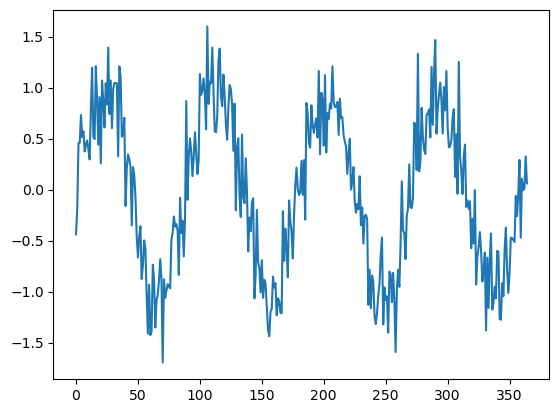

In [17]:
plt.plot(signal[:365])

In [ ]:
# use_ixs=None, c1=1e3, yearly_periodic=True
# <365 and >365

In [5]:
fname = "test_l1_l2d2p365_data_input.csv"
try:
    signal = pd.read_csv(fname)["test_signal"].array
    test_df = pd.DataFrame(signal, columns=["test_signal"])
except FileNotFoundError:
    test_df = pd.DataFrame(signal, columns=["test_signal"])

# cvxpy output w/ default args

# MOSEK
s_hat, s_seas = sd.l1_l2d2p365(signal, solver = "MOSEK")
test_df["expected_s_hat_mosek"] = s_hat
test_df["expected_s_seas_mosek"] = s_seas

# SCS 
s_hat, s_seas = sd.l1_l2d2p365(signal, solver = "SCS")
test_df["expected_s_hat_scs"] = s_hat
test_df["expected_s_seas_scs"] = s_seas

#############################################################
# Take first year of dataset
indices = list([True]*365) + list([False]*235)

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal, solver = "MOSEK", use_ixs=indices)
df_full["expected_s_hat_mosek_ixs"] = s_hat
df_full["expected_s_seas_mosek_ixs"] = s_seas

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal, solver = "SCS", use_ixs=indices)
df_full["expected_s_hat_scs_ixs"] = s_hat
df_full["expected_s_seas_scs_ixs"] = s_seas

#############################################################
# yearly periodic constraint, len has to be >365

# MOSEK
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal, solver = "MOSEK", yearly_periodic=True)
df_full["expected_s_hat_mosek_yearly_periodic"] = s_hat
df_full["expected_s_seas_mosek_yearly_periodic"] = s_seas

# SCS
s_hat, s_seas = sd.l2_l1d1_l2d2p365(signal, solver = "SCS", yearly_periodic=True)
df_full["expected_s_hat_mosek_yearly_periodic"] = s_hat
df_full["expected_s_seas_mosek_yearly_periodic"] = s_seas